# SemEval 2025 Task 9: The Food Hazard Detection Challenge

Sotirios Panagiotis Koulouridis 

## Preprocessing

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaModel,RobertaTokenizer,RobertaPreTrainedModel
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import numpy as np

### Modify Data Preprocessing

We load the dataset incidents_train.csv while setting the first column as the index.

In [2]:
data = pd.read_csv("incidents_train.csv", index_col=0)

# Keep only relevant columns that will be used for classification
data = data[["text", "hazard-category", "product-category"]]

# Drop any missing values to ensure clean data for training
data.dropna(inplace=True)

# Convert categorical labels to numerical values for machine learning models
hazard_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data["hazard-category"] = hazard_encoder.fit_transform(data["hazard-category"])
data["product-category"] = product_encoder.fit_transform(data["product-category"])

# Split the dataset into training and validation sets (80% train, 20% validation)
train_texts, val_texts, train_hazard_labels, val_hazard_labels, train_product_labels, val_product_labels = train_test_split(
    data["text"].tolist(),
    data["hazard-category"].tolist(),
    data["product-category"].tolist(),
    test_size=0.2, random_state=42
)


print("Data Loaded!")




Data Loaded!


### Tokenize text data

We use the `RobertaTokenizer` from Hugging Face's `transformers` library to preprocess text data for the RoBERTa model.

Since transformer-based models require tokenized input, we apply the tokenizer to both the training and validation text data.

- **Truncation**: Ensures that inputs exceeding the model’s maximum length (512 tokens) are truncated.
- **Padding**: Adds padding to shorter sequences so all inputs have the same length.
- **Max Length**: Restricts input size to 512 tokens for efficient processing.


In [3]:
# Initialize the RoBERTa tokenizer to preprocess text for the model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize training and validation texts, truncating or padding to max length 512
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

print("Data Tokenized Successfully!")



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Data Tokenized Successfully!


### Create PyTorch dataset class

We need a way to store our tokenized text along with their hazard and product labels. To do this, we define a custom PyTorch dataset class.

This class:
- Stores the tokenized text (`encodings`).
- Stores the hazard and product labels (`hazard_labels`, `product_labels`).

In [4]:
# Custom dataset class to store encoded texts and corresponding labels
class FoodHazardDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, hazard_labels, product_labels):
        self.encodings = encodings
        self.hazard_labels = hazard_labels
        self.product_labels = product_labels

    def __len__(self):
        return len(self.hazard_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["hazard_labels"] = torch.tensor(self.hazard_labels[idx])
        item["product_labels"] = torch.tensor(self.product_labels[idx])
        return item

# Convert processed data into PyTorch datasets for training and evaluation
train_dataset = FoodHazardDataset(train_encodings, train_hazard_labels, train_product_labels)
val_dataset = FoodHazardDataset(val_encodings, val_hazard_labels, val_product_labels)

print("Datasets created!")


Datasets created!


### Define RoBERTa model for multi-label classification

Since we’re predicting both **hazard categories** and **product categories**, we need to modify RoBERTa .

We extend `RobertaPreTrainedModel` to create `MultiLabelRoBERTa`, which includes:
- A **dropout layer** to prevent overfitting.
- Two **separate classifiers**: 
  - One for hazard classification.
  - One for product classification.
- A **cross-entropy loss function** for training.


The input is passed through **RoBERTa**. The output is processed by **dropout** and the two classifiers. If labels are provided, it computes **loss** (for training).

In [5]:
class MultiLabelRoBERTa(RobertaPreTrainedModel):  
    def __init__(self, config, num_hazard_labels, num_product_labels):
        super().__init__(config)
        self.roberta = RobertaModel(config)  # Ensure correct import
        self.dropout = nn.Dropout(0.4) # To prevent overfitting
        self.hazard_classifier = nn.Linear(config.hidden_size, num_hazard_labels)  # For hazard classification
        self.product_classifier = nn.Linear(config.hidden_size, num_product_labels) # For product classification 
        self.loss_fn = nn.CrossEntropyLoss()
    
    #If labels are provided, it computes loss (for training) . Otherwise, it simply returns logits.
    def forward(self, input_ids, attention_mask, hazard_labels=None, product_labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)  
        pooled_output = outputs.pooler_output
        hazard_logits = self.hazard_classifier(self.dropout(pooled_output))
        product_logits = self.product_classifier(self.dropout(pooled_output))

        loss = None
        if hazard_labels is not None and product_labels is not None:
            hazard_loss = self.loss_fn(hazard_logits, hazard_labels)
            product_loss = self.loss_fn(product_logits, product_labels)
            loss = (hazard_loss + product_loss) / 2

        return {"loss": loss, "hazard_logits": hazard_logits, "product_logits": product_logits}

    print("RoBERTa ready!")




RoBERTa ready!


### Define evaluation function

Function to calculate F1-score for both hazard and product classification

In [6]:
def evaluate_predictions(true_hazards, true_products, predicted_hazards, predicted_products):
    true_hazards = np.array(true_hazards)
    true_products = np.array(true_products)
    predicted_hazards = np.array(predicted_hazards)
    predicted_products = np.array(predicted_products)

    f1_hazard = f1_score(true_hazards, predicted_hazards, average="macro")
    correct_hazard_mask = (true_hazards == predicted_hazards)

    if correct_hazard_mask.any():
        f1_product = f1_score(true_products[correct_hazard_mask], predicted_products[correct_hazard_mask], average="macro")
    else:
        f1_product = 0

    overall_f1 = (f1_hazard + f1_product) / 2
    return {"F1_Hazard": f1_hazard, "F1_Product": f1_product, "Final_Score": overall_f1}


### Integrate evaluation with Hugging Face Trainer

Function to wrap the evaluation function for use in Hugging Face's Trainer


In [7]:
def compute_semeval_metrics(pred):
    true_hazards = pred.label_ids[0]
    true_products = pred.label_ids[1]
    predicted_hazards = pred.predictions[0].argmax(-1)
    predicted_products = pred.predictions[1].argmax(-1)
    return evaluate_predictions(true_hazards, true_products, predicted_hazards, predicted_products)


In [8]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## ST1: Text classification for food hazard prediction, predicting the type of hazard and product

### Train the model

Set up training arguments for fine-tuning RoBERTa .

In [9]:
training_args = TrainingArguments(
    output_dir="./results", # to save checkpoints
    eval_strategy="epoch",
    fp16=True,  # Use less memory
    save_total_limit=1, # keeps only the last checkpoint
    save_strategy="epoch", 
    save_only_model=True,
    logging_dir="./logs", # to save logs 
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,  # Simulates batch size 8
    num_train_epochs=10, # train for 10 full passes
    weight_decay=0.01, 
    learning_rate=3e-5 # low learning rate so we can have more stable learning
)

Here we fine-tune the model , then we begin training .

In [10]:
# Initialize the multi-label classification model
num_hazard_labels = len(set(train_hazard_labels))
num_product_labels = len(set(train_product_labels))
model = MultiLabelRoBERTa.from_pretrained("roberta-base", num_hazard_labels=num_hazard_labels, num_product_labels=num_product_labels)

# Define the Trainer for fine-tuning the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_semeval_metrics,
)

# Begin training
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of MultiLabelRoBERTa were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hazard_classifier.bias', 'hazard_classifier.weight', 'product_classifier.bias', 'product_classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Hazard,F1 Product,Final Score
1,1.421300,0.980987,0.458406,0.307762,0.383084
2,0.830600,0.688179,0.525738,0.441661,0.483699
3,0.571800,0.636289,0.639984,0.560905,0.600444
4,0.406800,0.593007,0.638351,0.616735,0.627543
5,0.309000,0.615782,0.654155,0.595197,0.624676
6,0.219800,0.627984,0.703733,0.591402,0.647568
7,0.169500,0.661250,0.697352,0.645554,0.671453
8,0.116500,0.688430,0.718162,0.618744,0.668453
9,0.073300,0.721713,0.707781,0.614757,0.661269


TrainOutput(global_step=5080, training_loss=0.4151332281705901, metrics={'train_runtime': 1264.6029, 'train_samples_per_second': 32.144, 'train_steps_per_second': 4.017, 'total_flos': 1.06791330275328e+16, 'train_loss': 0.4151332281705901, 'epoch': 9.981800295130348})

### Evaluate the trained model

In [11]:
trainer.evaluate()

{'eval_loss': 0.7217125296592712,
 'eval_F1_Hazard': 0.7077805000959663,
 'eval_F1_Product': 0.6147565653683743,
 'eval_Final_Score': 0.6612685327321703,
 'eval_runtime': 9.848,
 'eval_samples_per_second': 103.269,
 'eval_steps_per_second': 51.685,
 'epoch': 9.981800295130348}

### Generate predictions on test data

In [12]:
def generate_predictions(test_texts):
    encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    encodings.pop("token_type_ids", None)
    
    # Detect the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move model to the correct device
    model.to(device)
    
    # Move input tensors to the same device as the model
    encodings = {key: val.to(device) for key, val in encodings.items() if key != "token_type_ids"}  # Remove 'token_type_ids'
    
    # Run inference
    with torch.no_grad():
        outputs = model(**encodings)
    
    # Get predictions
    hazard_preds = outputs["hazard_logits"].argmax(-1).cpu().tolist()  # Move back to CPU for processing
    product_preds = outputs["product_logits"].argmax(-1).cpu().tolist()
    
    return hazard_encoder.inverse_transform(hazard_preds), product_encoder.inverse_transform(product_preds)



# Load test dataset
test_data = pd.read_csv("incidents_test.csv")
test_texts = test_data["text"].tolist()
hazard_predictions, product_predictions = generate_predictions(test_texts)

test_data["predicted_hazard"] = hazard_predictions
test_data["predicted_product"] = product_predictions

# Keep only required columns
test_data = test_data[["Unnamed: 0", "predicted_hazard", "predicted_product"]]

test_data.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv!")

Submission file saved as submission.csv!


In [13]:
# Print the first few rows to check predictions
print("First 5 Predictions:")
print(test_data[["Unnamed: 0", "predicted_hazard", "predicted_product"]].head())  

First 5 Predictions:
   Unnamed: 0 predicted_hazard             predicted_product
0           0   foreign bodies  meat, egg and dairy products
1           1   foreign bodies  meat, egg and dairy products
2           2   foreign bodies  meat, egg and dairy products
3           3       biological  meat, egg and dairy products
4           4   foreign bodies    prepared dishes and snacks


### Plotting

We have made a plot in order to observe how the `training loss` reduces in each pass of the training data. (epochs)

Matplotlib is building the font cache; this may take a moment.


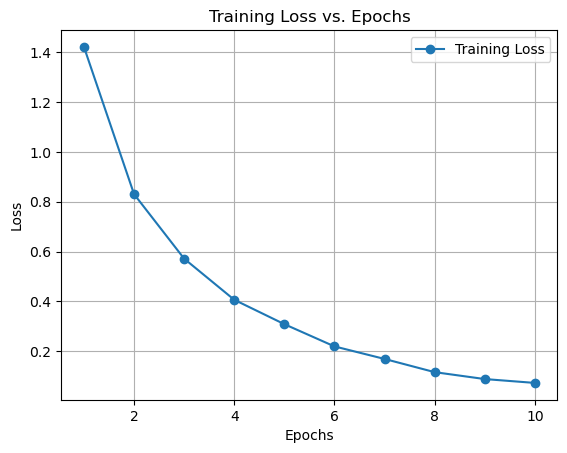

In [14]:
import matplotlib.pyplot as plt

# Extract loss values from Trainer logs
train_losses = trainer.state.log_history
train_loss_values = [entry['loss'] for entry in train_losses if 'loss' in entry]
epochs = list(range(1, len(train_loss_values) + 1))

# Plot
plt.plot(epochs, train_loss_values, marker="o", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()


## ST2: Food Hazard and Product "Vector" Detection

In [15]:
# Load the training dataset for ST2
data_st2 = pd.read_csv("incidents_train.csv")

# Display the first few rows to understand its structure
data_st2.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


### Preprocess Data for ST2

I tried using **spaCy’s NER** to extract named entities (like names, locations, and organizations) from text and add them as extra features.

I applied the function to extract NER features and combined them with the original text. It is an attempt to make the f1 score better. 

Tried to use `en_core_web_trf` but it was way too slow . Then tried to use `one-hot` labels but difficulty was too high . I have an experimental implementation at the end of the notebook. (Experimenting 1)

I also tried using the predictions from ST1 as features in the dataset of ST2, but I couldn't proceed due to errors. (Experimenting 2)

In [16]:
import spacy
#from sklearn.preprocessing import MultiLabelBinarizer

# Load spaCy NER model
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    """Extract named entities from text using spaCy"""
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return " ".join(entities) if entities else "NONE"  # Avoid empty NER fields

# Load data
data_st2["ner_features"] = data_st2["text"].apply(extract_entities)

# Combined with the original text.
data_st2["text_with_ner"] = data_st2["text"] + " [NER] " + data_st2["ner_features"]

# Encode hazard and product labels
hazard_encoder_st2 = LabelEncoder()
product_encoder_st2 = LabelEncoder()

data_st2["hazard"] = hazard_encoder_st2.fit_transform(data_st2["hazard"])
data_st2["product"] = product_encoder_st2.fit_transform(data_st2["product"])

# **Convert `hazard` & `product` labels to lists for MultiLabelBinarizer**
# data_st2["hazard"] = data_st2["hazard"].apply(lambda x: [x] if isinstance(x, int) else x)
# data_st2["product"] = data_st2["product"].apply(lambda x: [x] if isinstance(x, int) else x)

# # Use MultiLabelBinarizer for encoding labels
# hazard_encoder_st2 = MultiLabelBinarizer()
# product_encoder_st2 = MultiLabelBinarizer()

print("Preprocessing Completed!")

Preprocessing Completed!


### Tokenize and Prepare PyTorch Dataset for ST2

I used the `RobertaTokenizer` to tokenize `text_with_ner`, ensuring:
- **Truncation**: Texts longer than 512 tokens are cut.
- **Padding**: Shorter texts are padded to 512 tokens.
- **Return PyTorch tensors**: Data is returned in tensor format.

Since we are working with hazard and product labels, I created a PyTorch dataset class to store: `Tokenized text` , `Hazard labels` , `Product labels`

In [17]:
# Tokenize using roBERTa
st2_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
st2_encodings = st2_tokenizer(list(data_st2["text_with_ner"]), truncation=True, padding=True, max_length=512,return_tensors="pt")

# Remove token_type_ids before passing to model
st2_encodings.pop("token_type_ids", None)

class ST2Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, hazard_labels, product_labels):
        self.encodings = encodings
        self.hazard_labels = hazard_labels
        self.product_labels = product_labels

    def __len__(self):
        return len(self.hazard_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["hazard_labels"] = torch.tensor(self.hazard_labels[idx])
        item["product_labels"] = torch.tensor(self.product_labels[idx])
        return item

# Split the dataset into training (80%) and validation (20%)
train_texts_st2, val_texts_st2, train_hazards_st2, val_hazards_st2, train_products_st2, val_products_st2 = train_test_split(
    data_st2["text_with_ner"].tolist(),
    data_st2["hazard"].tolist(),
    data_st2["product"].tolist(),
    test_size=0.2, random_state=42
)

# Tokenize training and validation texts
train_encodings_st2 = st2_tokenizer(train_texts_st2, truncation=True, padding=True, max_length=512)
val_encodings_st2 = st2_tokenizer(val_texts_st2, truncation=True, padding=True, max_length=512)

# Convert tokenized data to PyTorch dataset
train_dataset_st2 = ST2Dataset(train_encodings_st2, train_hazards_st2, train_products_st2)
val_dataset_st2 = ST2Dataset(val_encodings_st2, val_hazards_st2, val_products_st2)

print("Tokenization completed!")

Tokenization completed!


### Funtion to compute f1 score

In [18]:
def compute_f1_score_st2(eval_pred):
    logits, labels = eval_pred  

    # Split logits for hazard & product classification
    logits_hazard, logits_product = logits

    # Convert logits to predicted labels
    hazard_preds = np.argmax(logits_hazard, axis=-1)
    product_preds = np.argmax(logits_product, axis=-1)

    # Unpack true labels
    hazard_labels, product_labels = labels

    # Compute F1-score for hazard classification
    f1_hazard = f1_score(hazard_labels, hazard_preds, average="macro")

    # Compute F1-score for product classification (only when hazard is correct)
    correct_hazard_mask = (hazard_labels == hazard_preds)

    if correct_hazard_mask.any():
        f1_product = f1_score(np.array(product_labels)[correct_hazard_mask], np.array(product_preds)[correct_hazard_mask], average="macro")
    else:
        f1_product = 0

    # Compute final ST2 score
    final_f1_score = (f1_hazard + f1_product) / 2

    return {"F1_Hazard": f1_hazard, "F1_Product": f1_product, "Final_F1_Score": final_f1_score}

print("ok")

ok


Empty cache

In [19]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

### Train ST2 Model

Here we fine-tune the model , then we begin training .

In [20]:
st2_model = MultiLabelRoBERTa.from_pretrained("roberta-base", num_hazard_labels=len(set(data_st2["hazard"])), num_product_labels=len(set(data_st2["product"])))

st2_trainer = Trainer(
    model=st2_model,
    args=training_args,
    train_dataset=train_dataset_st2,
    eval_dataset=val_dataset_st2,  
    compute_metrics=compute_f1_score_st2  
)

st2_trainer.train()

Some weights of MultiLabelRoBERTa were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hazard_classifier.bias', 'hazard_classifier.weight', 'product_classifier.bias', 'product_classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Hazard,F1 Product,Final F1 Score
1,4.494900,3.822509,0.147359,0.001527,0.074443
2,3.616300,3.557470,0.248647,0.007675,0.128161
3,3.318900,3.391245,0.310963,0.010708,0.160835
4,3.074900,3.249994,0.417650,0.025334,0.221492
5,2.916000,3.171108,0.420650,0.027798,0.224224
6,2.750800,3.110565,0.443583,0.039798,0.241691
7,2.631200,3.069985,0.446114,0.041191,0.243652
8,2.526000,3.028808,0.458933,0.043122,0.251027
9,2.385200,2.986837,0.460850,0.047667,0.254258


TrainOutput(global_step=5080, training_loss=3.005067930446835, metrics={'train_runtime': 1344.238, 'train_samples_per_second': 30.24, 'train_steps_per_second': 3.779, 'total_flos': 1.0786302055016448e+16, 'train_loss': 3.005067930446835, 'epoch': 9.981800295130348})

### Evaluate the trained model 

In [21]:
st2_trainer.evaluate()

{'eval_loss': 2.9868366718292236,
 'eval_F1_Hazard': 0.4608498441859284,
 'eval_F1_Product': 0.0476668808097686,
 'eval_Final_F1_Score': 0.2542583624978485,
 'eval_runtime': 9.9086,
 'eval_samples_per_second': 102.639,
 'eval_steps_per_second': 51.37,
 'epoch': 9.981800295130348}

### Generate predictions on test data 

In [22]:
import torch
import pandas as pd

def generate_predictions_st2(test_texts):
    encodings = st2_tokenizer(test_texts, truncation=True, padding="longest", max_length=128, return_tensors="pt")

    encodings.pop("token_type_ids", None)  # Remove 'token_type_ids' if exists
    
    # Detect the device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move model to the correct device
    st2_model.to(device)
    
    # Move input tensors to the same device as the model
    encodings = {key: val.to(device) for key, val in encodings.items()}

    # Run inference
    with torch.no_grad():
        outputs = st2_model(**encodings)

    # Get predictions
    hazard_preds = outputs["hazard_logits"].argmax(-1).cpu().tolist()
    product_preds = outputs["product_logits"].argmax(-1).cpu().tolist()

    return hazard_encoder_st2.inverse_transform(hazard_preds), product_encoder_st2.inverse_transform(product_preds)

# Load test dataset for ST2
test_data_st2 = pd.read_csv("incidents_test.csv")
test_texts_st2 = test_data_st2["text"].tolist()

# Batch inference to avoid CUDA OOM
batch_size = 16  # Adjust based on available GPU memory

hazard_predictions_st2 = []
product_predictions_st2 = []

for i in range(0, len(test_texts_st2), batch_size):
    batch = test_texts_st2[i:i + batch_size]
    h_preds, p_preds = generate_predictions_st2(batch)
    hazard_predictions_st2.extend(h_preds)
    product_predictions_st2.extend(p_preds)

# Store predictions in DataFrame
test_data_st2["predicted_hazard"] = hazard_predictions_st2
test_data_st2["predicted_product"] = product_predictions_st2

# Keep only required columns
test_data_st2 = test_data_st2[["Unnamed: 0", "predicted_hazard", "predicted_product"]]

# Save submission file
test_data_st2.to_csv("submission_st2.csv", index=False)
print("Submission file saved as submission_st2.csv!")


Submission file saved as submission_st2.csv!


### Show some predictions

In [23]:
# Print the first few rows to check predictions
print("First 5 Predictions:")
print(test_data_st2[["Unnamed: 0", "predicted_hazard", "predicted_product"]].head())  

First 5 Predictions:
   Unnamed: 0        predicted_hazard       predicted_product
0           0        plastic fragment  chicken based products
1           1        plastic fragment  chicken based products
2           2        plastic fragment  chicken based products
3           3  listeria monocytogenes                     ham
4           4          metal fragment               ice cream


### Plotting 

We have made a plot in order to observe how the `training loss` reduces in each pass of the training data. (epochs)

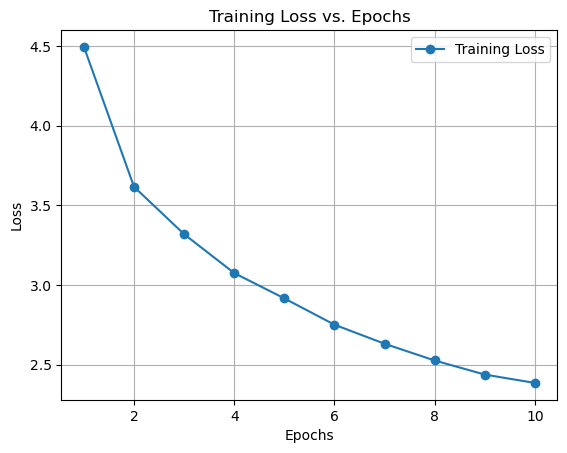

In [24]:
import matplotlib.pyplot as plt

# Extract loss values from Trainer logs
train_losses = st2_trainer.state.log_history
train_loss_values = [entry['loss'] for entry in train_losses if 'loss' in entry]
epochs = list(range(1, len(train_loss_values) + 1))

# Plot
plt.plot(epochs, train_loss_values, marker="o", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()


We have made a plot in order to observe the distribution of predicted probabilities .

In [25]:
import torch

# Generate predictions from the trained model
predictions = st2_trainer.predict(val_dataset).predictions

# Apply sigmoid to get probabilities (since it's multi-label classification)
probs = torch.sigmoid(torch.tensor(predictions[0])).numpy()



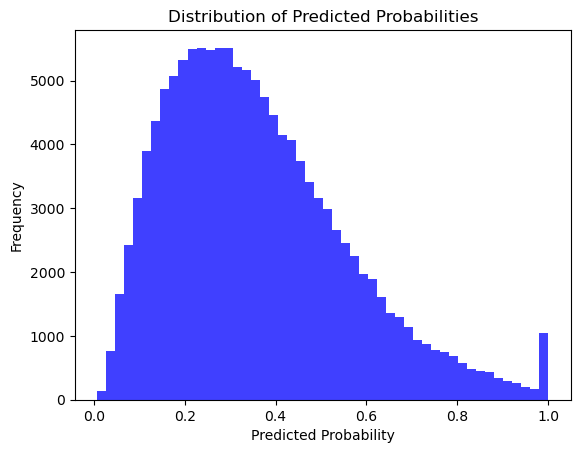

In [26]:
import matplotlib.pyplot as plt

plt.hist(probs.ravel(), bins=50, alpha=0.75, color="blue")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()


## Experimenting 1

I searched that by using a different loss function for st2 f1 score will be enhanced . 

Tried to use `BCEWithLogitsLoss` as a loss function, but I could not understand how to correctly turn my data into `one-hot labels` and use them effectively. 

But , I experimented by trying to optimise my ST2 , so I made a new RoBERTa (supports both **CrossEntropyLoss** and **BCEWithLogitsLoss** ) and changed the stracture of my ST2 .

### RoBERTa

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaPreTrainedModel, RobertaModel

class MultiTaskRoBERTa(RobertaPreTrainedModel):
    def __init__(self, config, num_hazard_labels, num_product_labels, task="st1"):
        super().__init__(config)
        self.roberta = RobertaModel(config)  # Shared RoBERTa backbone
        self.dropout = nn.Dropout(0.4)

        # ST1: Single-label classification (softmax output)
        self.hazard_classifier_st1 = nn.Linear(config.hidden_size, num_hazard_labels)
        self.product_classifier_st1 = nn.Linear(config.hidden_size, num_product_labels)

        # ST2: Multi-label classification (sigmoid output)
        self.hazard_classifier_st2 = nn.Linear(config.hidden_size, num_hazard_labels)
        self.product_classifier_st2 = nn.Linear(config.hidden_size, num_product_labels)

        # Store task type
        self.task = task

        # Loss functions
        self.loss_fct_st1 = nn.CrossEntropyLoss()  # Single-label
        self.loss_fct_st2 = nn.BCEWithLogitsLoss()  # Multi-label

    def forward(self, input_ids, attention_mask, hazard_labels=None, product_labels=None, task=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output if outputs.pooler_output is not None else outputs.last_hidden_state[:, 0, :]

        # Choose classifier based on task
        task = task if task else self.task
        if task == "st1":  
            hazard_logits = self.hazard_classifier_st1(self.dropout(pooled_output))
            product_logits = self.product_classifier_st1(self.dropout(pooled_output))
        elif task == "st2":  
            hazard_logits = self.hazard_classifier_st2(self.dropout(pooled_output))
            product_logits = self.product_classifier_st2(self.dropout(pooled_output))
        else:
            raise ValueError("Invalid task. Choose 'st1' or 'st2'.")

        # Compute loss
        loss = None
        if hazard_labels is not None and product_labels is not None:
            if task == "st1":
                hazard_loss = self.loss_fct_st1(hazard_logits, hazard_labels.long())  
                product_loss = self.loss_fct_st1(product_logits, product_labels.long())  
            else:  # task == "st2"
                hazard_loss = self.loss_fct_st2(hazard_logits, hazard_labels.float())  
                product_loss = self.loss_fct_st2(product_logits, product_labels.float())  

            loss = (hazard_loss + product_loss) / 2  # Average loss

        return {"loss": loss, "hazard_logits": hazard_logits, "product_logits": product_logits}


### Preprocess Data for ST2

In [ ]:
import spacy
import pandas as pd
import torch
from sklearn.preprocessing import MultiLabelBinarizer

# Load spaCy NER model
nlp = spacy.load("en_core_web_trf")

def extract_entities(text):
    """Extract named entities from text using spaCy"""
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return " ".join(entities) if entities else "NONE"  

# Apply Named Entity Recognition (NER) to extract entities
data_st2["ner_features"] = data_st2["text"].apply(extract_entities)
data_st2["text_with_ner"] = data_st2["text"] + " [NER] " + data_st2["ner_features"]

# Convert hazard and product labels to lists if they are not already
data_st2["hazard"] = data_st2["hazard"].apply(lambda x: x if isinstance(x, list) else [x])
data_st2["product"] = data_st2["product"].apply(lambda x: x if isinstance(x, list) else [x])

# Use MultiLabelBinarizer for one-hot encoding
hazard_encoder = MultiLabelBinarizer()
product_encoder = MultiLabelBinarizer()

data_st2["hazard_one_hot"] = list(hazard_encoder.fit_transform(data_st2["hazard"]))
data_st2["product_one_hot"] = list(product_encoder.fit_transform(data_st2["product"]))

# Get number of unique labels for training
num_hazard_labels = len(hazard_encoder.classes_)
num_product_labels = len(product_encoder.classes_)

# Print summary
print("NER Applied & Labels One-Hot Encoded.")
print(f" Hazard classes: {num_hazard_labels}")
print(f" Product classes: {num_product_labels}")


NER Applied & Labels One-Hot Encoded.
 Hazard classes: 128
 Product classes: 1022


### Tokenize and Prepare PyTorch Dataset for ST2

In [ ]:
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Initialize RoBERTa tokenizer
st2_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class ST2Dataset(Dataset):
    def __init__(self, texts, hazard_labels, product_labels):
        self.encodings = st2_tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
        self.hazard_labels = torch.tensor(hazard_labels, dtype=torch.float32)
        self.product_labels = torch.tensor(product_labels, dtype=torch.float32)

    def __len__(self):
        return len(self.hazard_labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["hazard_labels"] = self.hazard_labels[idx]
        item["product_labels"] = self.product_labels[idx]
        return item

# Split the dataset into training (80%) and validation (20%)
train_texts, val_texts, train_hazards, val_hazards, train_products, val_products = train_test_split(
    data_st2["text_with_ner"].tolist(),
    data_st2["hazard_one_hot"].tolist(),
    data_st2["product_one_hot"].tolist(),
    test_size=0.2, random_state=42
)

# Create PyTorch datasets
train_dataset = ST2Dataset(train_texts, train_hazards, train_products)
val_dataset = ST2Dataset(val_texts, val_hazards, val_products)


In [ ]:
print("Sample Hazard Labels (One-Hot):", data_st2["hazard_one_hot"].iloc[0])
print("Sample Product Labels (One-Hot):", data_st2["product_one_hot"].iloc[0])


Sample Hazard Labels (One-Hot): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample Product Labels (One-Hot): [0 0 0 ... 0 0 0]


### Funtion to compute f1 score

In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score

def compute_f1_score_st2(eval_pred):
    logits, labels = eval_pred  

    # Apply sigmoid activation for multi-label classification
    hazard_logits, product_logits = logits
    hazard_probs = torch.sigmoid(torch.tensor(hazard_logits)).numpy()
    product_probs = torch.sigmoid(torch.tensor(product_logits)).numpy()

    # Convert probabilities to binary predictions (threshold = 0.5)
    hazard_preds = (hazard_probs > 0.5).astype(int)
    product_preds = (product_probs > 0.5).astype(int)

    # Check if labels are non-empty before computing F1-score
    if labels[0].sum() == 0 and labels[1].sum() == 0:
        return {"F1_Hazard": 0.0, "F1_Product": 0.0, "Final_F1_Score": 0.0}

    # Compute F1-score with zero_division=1 to avoid undefined metrics
    f1_hazard = f1_score(labels[0], hazard_preds, average="macro", zero_division=1)
    f1_product = f1_score(labels[1], product_preds, average="macro", zero_division=1)

    # Compute final ST2 score
    final_f1_score = (f1_hazard + f1_product) / 2

    return {"F1_Hazard": f1_hazard, "F1_Product": f1_product, "Final_F1_Score": final_f1_score}


### Train ST2 Model

In [ ]:
from transformers import Trainer, TrainingArguments, RobertaConfig

# Load model configuration
config = RobertaConfig.from_pretrained("roberta-base")
config.num_hazard_labels = num_hazard_labels
config.num_product_labels = num_product_labels

# Initialize model
st2_model = MultiTaskRoBERTa.from_pretrained(
    "roberta-base",
    config=config,
    num_hazard_labels=num_hazard_labels,
    num_product_labels=num_product_labels,
    task="st2"
)

# Initialize Trainer
st2_trainer = Trainer(
    model=st2_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start Training
st2_trainer.train()



Some weights of MultiTaskRoBERTa were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hazard_classifier_st2.bias', 'hazard_classifier_st2.weight', 'loss_fct_st2.pos_weight', 'loss_fct_st2_product.pos_weight', 'product_classifier_st2.bias', 'product_classifier_st2.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.044300,0.040710


TrainOutput(global_step=1016, training_loss=0.08948739664995764, metrics={'train_runtime': 253.8401, 'train_samples_per_second': 32.028, 'train_steps_per_second': 4.003, 'total_flos': 2158749020104704.0, 'train_loss': 0.08948739664995764, 'epoch': 1.9975405804230202})

## Experimenting 2 

### Trying to implement st1 predictions as features 

In [ ]:
import spacy
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MultiLabelBinarizer

# Load spaCy NER model
nlp = spacy.load("en_core_web_sm")

# def extract_entities(text):
#     """Extract named entities from text using spaCy"""
#     doc = nlp(text)
#     entities = [ent.text for ent in doc.ents]
#     return " ".join(entities) if entities else "NONE"  # Avoid empty NER fields

# # Load data
# data_st2["ner_features"] = data_st2["text"].apply(extract_entities)

# Combined with the original text.
data_st2["text_with_ner"] = data_st2["text"] 

# + " [NER] " + data_st2["ner_features"]

# Encode ST1 hazard and product predictions
st1_hazard_encoder = LabelEncoder()
st1_product_encoder = LabelEncoder()

st1_dataset["st1_hazard_encoded"] = st1_hazard_encoder.fit_transform(st1_dataset["predicted_hazard"])
st1_dataset["st1_product_encoded"] = st1_product_encoder.fit_transform(st1_dataset["predicted_product"])


# Encode hazard and product labels
hazard_encoder_st2 = LabelEncoder()
product_encoder_st2 = LabelEncoder()

data_st2["hazard"] = hazard_encoder_st2.fit_transform(data_st2["hazard"])
data_st2["product"] = product_encoder_st2.fit_transform(data_st2["product"])

data_st2["st1_hazard_feature"] = st1_dataset["st1_hazard_encoded"]
data_st2["st1_product_feature"] = st1_dataset["st1_product_encoded"]

# **Convert `hazard` & `product` labels to lists for MultiLabelBinarizer**
# data_st2["hazard"] = data_st2["hazard"].apply(lambda x: [x] if isinstance(x, int) else x)
# data_st2["product"] = data_st2["product"].apply(lambda x: [x] if isinstance(x, int) else x)

# # Use MultiLabelBinarizer for encoding labels
# hazard_encoder_st2 = MultiLabelBinarizer()
# product_encoder_st2 = MultiLabelBinarizer()

print("Preprocessing Completed!")

### Creation of PyTorch dataset class to store: `Tokenized text` , `Hazard labels` , `Product labels`

In [ ]:
# Ensure all values in `text_with_ner` are strings and fill NaN values
data_st2["text_with_ner"] = data_st2["text_with_ner"].astype(str).fillna("")

# Tokenize using roBERTa
st2_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
st2_encodings = st2_tokenizer(list(data_st2["text_with_ner"]), truncation=True, padding=True, max_length=512,return_tensors="pt")

# Remove token_type_ids before passing to model
st2_encodings.pop("token_type_ids", None)

import torch

class ST2Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, hazard_labels, product_labels, st1_hazard=None, st1_product=None):
        self.encodings = encodings
        self.hazard_labels = hazard_labels
        self.product_labels = product_labels
        self.st1_hazard = st1_hazard
        self.st1_product = st1_product

    def __len__(self):
        return len(self.hazard_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["hazard_labels"] = torch.tensor(self.hazard_labels[idx])
        item["product_labels"] = torch.tensor(self.product_labels[idx])

        # Add ST1 features as structured inputs
        if self.st1_hazard is not None and self.st1_product is not None:
            item["st1_hazard"] = torch.tensor(self.st1_hazard[idx])
            item["st1_product"] = torch.tensor(self.st1_product[idx])

        return item


# Split the dataset into training (80%) and validation (20%)
train_texts_st2, val_texts_st2, train_hazards_st2, val_hazards_st2, train_products_st2, val_products_st2 = train_test_split(
    data_st2["text_with_ner"].tolist(),
    data_st2["hazard"].tolist(),
    data_st2["product"].tolist(),
    test_size=0.2, random_state=42
)

# Tokenize training and validation texts
train_encodings_st2 = st2_tokenizer(train_texts_st2, truncation=True, padding=True, max_length=512)
val_encodings_st2 = st2_tokenizer(val_texts_st2, truncation=True, padding=True, max_length=512)

# Convert tokenized data to PyTorch dataset

train_features = {
    "input_ids": train_encodings_st2["input_ids"],
    "attention_mask": train_encodings_st2["attention_mask"],
    "st1_hazard": torch.tensor(data_st2["st1_hazard_feature"]),
    "st1_product": torch.tensor(data_st2["st1_product_feature"])
}

# Train dataset with ST1 predictions as extra inputs
train_dataset_st2 = ST2Dataset(
    train_encodings_st2,
    train_hazards_st2,
    train_products_st2,
    st1_hazard=train_features["st1_hazard"],  # Pass ST1 hazard predictions
    st1_product=train_features["st1_product"]  # Pass ST1 product predictions
)

# Validation dataset (without ST1)
val_dataset_st2 = ST2Dataset(
    val_encodings_st2,
    val_hazards_st2,
    val_products_st2
)

print("Tokenization completed!")